In [28]:
# ============================================================================
# IMPORTACIÓN DE LIBRERÍAS
# ============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficos
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("=" * 90)
print("MODELO RNN OPTIMIZADO PARA PREDICCIÓN DE DOGECOIN (DOGE-USD)")
print("Objetivo: MAPE < 5% | Predicción: 6 días consecutivos")
print("=" * 90)

MODELO RNN OPTIMIZADO PARA PREDICCIÓN DE DOGECOIN (DOGE-USD)
Objetivo: MAPE < 5% | Predicción: 6 días consecutivos


In [29]:
# ============================================================================
# 1️⃣ PREPARACIÓN DE DATOS
# ============================================================================
print("\n[1/6] PREPARANDO LOS DATOS...")
print("-" * 90)

# Descarga de datos desde Yahoo Finance
print("📊 Descargando datos de DOGE-USD desde Yahoo Finance...")
df = yf.download("DOGE-USD", start="2020-01-01", end="2024-12-31", progress=False)

# Verificación de datos
print(f"✓ Datos descargados: {len(df)} registros")
print(f"✓ Rango de fechas: {df.index[0].date()} a {df.index[-1].date()}")

# Selección de la columna de precio de cierre
data = df['Close'].values.reshape(-1, 1)
fechas = df.index
ultima_fecha = fechas[-1]

print(f"\n📅 Última fecha de observación: {ultima_fecha.date()}")
print(f"💰 Último precio observado: ${data[-1, 0]:.6f}")

# Normalización de datos (escala 0-1)
print("\n🔧 Normalizando datos con MinMaxScaler...")
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)
print(f"✓ Datos normalizados en el rango [{data_scaled.min():.4f}, {data_scaled.max():.4f}]")

# Creación de secuencias temporales con LOOKBACK optimizado
LOOKBACK = 90  # Aumentado a 90 días para mejor captura de patrones

def crear_secuencias(datos, lookback):
    """
    Crea secuencias temporales para entrenamiento del modelo RNN
    
    Args:
        datos: Array de datos normalizados
        lookback: Número de pasos temporales previos a considerar
    
    Returns:
        X: Secuencias de entrada (lookback, features)
        y: Valores objetivo
    """
    X, y = [], []
    for i in range(lookback, len(datos)):
        X.append(datos[i-lookback:i, 0])
        y.append(datos[i, 0])
    return np.array(X), np.array(y)

print(f"\n🔧 Creando secuencias temporales (LOOKBACK = {LOOKBACK} días - optimizado)...")
X, y = crear_secuencias(data_scaled, LOOKBACK)
print(f"✓ Secuencias creadas: X.shape = {X.shape}, y.shape = {y.shape}")

# División en conjuntos de entrenamiento y prueba (85%-15% para más datos de entrenamiento)
split_ratio = 0.85
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

fechas_train = fechas[LOOKBACK:LOOKBACK+split_index]
fechas_test = fechas[LOOKBACK+split_index:]

print(f"\n📊 División de datos (optimizada para mejor entrenamiento):")
print(f"   • Entrenamiento: {len(X_train)} secuencias ({split_ratio*100:.0f}%)")
print(f"   • Prueba: {len(X_test)} secuencias ({(1-split_ratio)*100:.0f}%)")

# Reshape para RNN [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"✓ Reshape completado: X_train.shape = {X_train.shape}, X_test.shape = {X_test.shape}")


[1/6] PREPARANDO LOS DATOS...
------------------------------------------------------------------------------------------
📊 Descargando datos de DOGE-USD desde Yahoo Finance...
✓ Datos descargados: 1826 registros
✓ Rango de fechas: 2020-01-01 a 2024-12-30

📅 Última fecha de observación: 2024-12-30
💰 Último precio observado: $0.313514

🔧 Normalizando datos con MinMaxScaler...
✓ Datos normalizados en el rango [0.0000, 1.0000]

🔧 Creando secuencias temporales (LOOKBACK = 90 días - optimizado)...
✓ Secuencias creadas: X.shape = (1736, 90), y.shape = (1736,)

📊 División de datos (optimizada para mejor entrenamiento):
   • Entrenamiento: 1475 secuencias (85%)
   • Prueba: 261 secuencias (15%)
✓ Reshape completado: X_train.shape = (1475, 90, 1), X_test.shape = (261, 90, 1)


In [30]:
#============================================================================
# 2️⃣ DEFINICIÓN DEL MODELO RNN OPTIMIZADO
# ============================================================================
print("\n[2/6] DEFINIENDO EL MODELO RNN OPTIMIZADO...")
print("-" * 90)

modelo = Sequential([
    # Primera capa RNN - aumentada para mejor captura de patrones
    SimpleRNN(units=128, activation='tanh', return_sequences=True, 
              input_shape=(X_train.shape[1], 1), name='RNN_Layer_1'),
    Dropout(0.3, name='Dropout_1'),
    
    # Segunda capa RNN
    SimpleRNN(units=64, activation='tanh', return_sequences=True, 
              name='RNN_Layer_2'),
    Dropout(0.3, name='Dropout_2'),
    
    # Tercera capa RNN
    SimpleRNN(units=32, activation='tanh', return_sequences=False, 
              name='RNN_Layer_3'),
    Dropout(0.2, name='Dropout_3'),
    
    # Capas densas para la predicción
    Dense(units=32, activation='relu', name='Dense_1'),
    Dense(units=16, activation='relu', name='Dense_2'),
    Dense(units=1, name='Output_Layer')
])

# Compilación del modelo con learning rate optimizado
optimizer = Adam(learning_rate=0.0005)  # Learning rate reducido para mejor convergencia
modelo.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mape'])

print("\n🧠 Arquitectura del modelo OPTIMIZADO:")
modelo.summary()


[2/6] DEFINIENDO EL MODELO RNN OPTIMIZADO...
------------------------------------------------------------------------------------------

🧠 Arquitectura del modelo OPTIMIZADO:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ RNN_Layer_1 (SimpleRNN)         │ (None, 90, 128)        │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 90, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ RNN_Layer_2 (SimpleRNN)         │ (None, 90, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 90, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ RNN_Layer_3 (SimpleRNN)         │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,697 (131.63 KB)

 Trainable params: 33,697 (131.63 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# ============================================================================
# 3️⃣ ENTRENAMIENTO DEL MODELO
# ============================================================================
print("\n[3/6] ENTRENANDO EL MODELO OPTIMIZADO...")
print("-" * 90)

# Configuración de callbacks optimizados
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, 
                      min_lr=0.000001, verbose=1),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, 
                  verbose=1)
]

# Entrenamiento con más épocas
EPOCHS = 100
BATCH_SIZE = 16  # Batch size reducido para mejor aprendizaje

print(f"🚀 Iniciando entrenamiento (EPOCHS={EPOCHS}, BATCH_SIZE={BATCH_SIZE})...")
print("⏳ Esto puede tomar varios minutos...\n")

history = modelo.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Entrenamiento completado exitosamente!")


[3/6] ENTRENANDO EL MODELO OPTIMIZADO...
------------------------------------------------------------------------------------------
🚀 Iniciando entrenamiento (EPOCHS=100, BATCH_SIZE=16)...
⏳ Esto puede tomar varios minutos...

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0794 - mae: 0.2180 - mape: 3299.1338 - val_loss: 0.0081 - val_mae: 0.0859 - val_mape: 75.7159 - learning_rate: 5.0000e-04
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0355 - mae: 0.1470 - mape: 2169.0867 - val_loss: 0.0036 - val_mae: 0.0546 - val_mape: 41.8438 - learning_rate: 5.0000e-04
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0184 - mae: 0.1012 - mape: 1176.2773 - val_loss: 0.0014 - val_mae: 0.0350 - val_mape: 28.1353 - learning_rate: 5.0000e-04
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0119 - mae: 0.0814 - mape: 986.3651 - val_loss: 0.0013 - val_mae: 0.0348 - val_mape: 29.4942 - learning_rate: 5.0000e-04
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━

In [32]:
# ============================================================================
# 4️⃣ EVALUACIÓN DEL MODELO
# ============================================================================
print("\n[4/6] EVALUANDO EL MODELO...")
print("-" * 90)

# Predicciones
print("🔮 Generando predicciones...")
y_pred_train = modelo.predict(X_train, verbose=0)
y_pred_test = modelo.predict(X_test, verbose=0)

# Desnormalización de las predicciones
y_train_real = scaler.inverse_transform(y_train.reshape(-1, 1))
y_pred_train_real = scaler.inverse_transform(y_pred_train)

y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_test_real = scaler.inverse_transform(y_pred_test)

# Cálculo de métricas
def calcular_metricas(y_real, y_pred, conjunto):
    """Calcula y muestra las métricas de evaluación"""
    mae = mean_absolute_error(y_real, y_pred)
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    mape = mean_absolute_percentage_error(y_real, y_pred) * 100
    
    # Símbolo de logro si MAPE < 5%
    mape_status = "✅ OBJETIVO ALCANZADO" if mape < 5.0 else "⚠️ Por encima del objetivo"
    
    print(f"\n{'='*50}")
    print(f"📊 MÉTRICAS - Conjunto de {conjunto}")
    print(f"{'='*50}")
    print(f"   • MAE (Error Absoluto Medio):        ${mae:.6f}")
    print(f"   • RMSE (Raíz del Error Cuadrático): ${rmse:.6f}")
    print(f"   • MAPE (Error Porcentual):           {mape:.4f}% {mape_status}")
    print(f"{'='*50}")
    
    return mae, rmse, mape

mae_train, rmse_train, mape_train = calcular_metricas(y_train_real, y_pred_train_real, "Entrenamiento")
mae_test, rmse_test, mape_test = calcular_metricas(y_test_real, y_pred_test_real, "Prueba")

# Crear tabla comparativa para mostrar en pantalla
print("\n" + "=" * 110)
print("📋 TABLA COMPARATIVA: VALORES REALES VS PREDICCIONES (ÚLTIMAS 30 OBSERVACIONES DEL CONJUNTO DE PRUEBA)")
print("=" * 110)

tabla_comparacion = pd.DataFrame({
    'Fecha': fechas_test[-30:],
    'Precio Real ($)': y_test_real[-30:].flatten(),
    'Precio Predicho ($)': y_pred_test_real[-30:].flatten(),
    'Error Absoluto ($)': np.abs(y_test_real[-30:] - y_pred_test_real[-30:]).flatten(),
    'Error (%)': (np.abs(y_test_real[-30:] - y_pred_test_real[-30:]) / y_test_real[-30:] * 100).flatten()
})

tabla_comparacion['Fecha'] = tabla_comparacion['Fecha'].dt.strftime('%Y-%m-%d')

pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.6f}')

print(tabla_comparacion.to_string(index=False))
print("=" * 110)


[4/6] EVALUANDO EL MODELO...
------------------------------------------------------------------------------------------
🔮 Generando predicciones...

📊 MÉTRICAS - Conjunto de Entrenamiento
   • MAE (Error Absoluto Medio):        $0.009056
   • RMSE (Raíz del Error Cuadrático): $0.016998
   • MAPE (Error Porcentual):           80.7277% ⚠️ Por encima del objetivo

📊 MÉTRICAS - Conjunto de Prueba
   • MAE (Error Absoluto Medio):        $0.011525
   • RMSE (Raíz del Error Cuadrático): $0.018579
   • MAPE (Error Porcentual):           5.7579% ⚠️ Por encima del objetivo

📋 TABLA COMPARATIVA: VALORES REALES VS PREDICCIONES (ÚLTIMAS 30 OBSERVACIONES DEL CONJUNTO DE PRUEBA)
     Fecha  Precio Real ($)  Precio Predicho ($)  Error Absoluto ($)  Error (%)
2024-12-01         0.440023             0.400037            0.039986   9.087255
2024-12-02         0.424670             0.402658            0.022012   5.183416
2024-12-03         0.407882             0.394758            0.013124   3.217609
2024-1

In [33]:
# ============================================================================
# 5️⃣ PREDICCIÓN DE LOS PRÓXIMOS 6 DÍAS CONSECUTIVOS
# ============================================================================
print("\n[5/6] GENERANDO PREDICCIONES PARA LOS PRÓXIMOS 6 DÍAS CONSECUTIVOS...")
print("-" * 90)

# Función para predecir múltiples pasos hacia adelante
def predecir_futuro(modelo, ultimos_datos, scaler, dias_futuro=6):
    """
    Predice los próximos N días CONSECUTIVOS usando predicciones recursivas
    
    Args:
        modelo: Modelo RNN entrenado
        ultimos_datos: Últimos LOOKBACK datos normalizados
        scaler: Scaler usado para normalización
        dias_futuro: Número de días consecutivos a predecir
    
    Returns:
        predicciones: Array con las predicciones desnormalizadas
    """
    predicciones = []
    entrada_actual = ultimos_datos.copy()
    
    for dia in range(dias_futuro):
        # Reshape para predicción
        entrada_reshape = entrada_actual.reshape(1, LOOKBACK, 1)
        
        # Predecir siguiente valor
        prediccion = modelo.predict(entrada_reshape, verbose=0)
        predicciones.append(prediccion[0, 0])
        
        # Actualizar entrada: remover el primer valor y añadir la predicción
        entrada_actual = np.append(entrada_actual[1:], prediccion[0, 0])
    
    # Desnormalizar predicciones
    predicciones = np.array(predicciones).reshape(-1, 1)
    predicciones_reales = scaler.inverse_transform(predicciones)
    
    return predicciones_reales

# Obtener los últimos LOOKBACK días de datos
ultimos_datos = data_scaled[-LOOKBACK:]

# Generar predicciones para los próximos 6 días CONSECUTIVOS
print(f"🔮 Prediciendo los próximos 6 días CONSECUTIVOS desde {ultima_fecha.date()}...")
predicciones_futuras = predecir_futuro(modelo, ultimos_datos, scaler, dias_futuro=6)

# Generar fechas futuras CONSECUTIVAS (incluyendo fines de semana)
fechas_futuras = []
for i in range(1, 7):
    fecha_futura = ultima_fecha + timedelta(days=i)
    fechas_futuras.append(fecha_futura)

# Crear tabla de predicciones futuras
print("\n" + "=" * 90)
print("🔮 PREDICCIONES PARA LOS PRÓXIMOS 6 DÍAS CONSECUTIVOS")
print("=" * 90)

tabla_futura = pd.DataFrame({
    'Día': ['Día +1', 'Día +2', 'Día +3', 'Día +4', 'Día +5', 'Día +6'],
    'Fecha': fechas_futuras,
    'Precio Predicho ($)': predicciones_futuras.flatten(),
    'Cambio vs Día Anterior ($)': [predicciones_futuras[0, 0] - data[-1, 0]] + 
                                   [predicciones_futuras[i, 0] - predicciones_futuras[i-1, 0] for i in range(1, 6)],
    'Cambio vs Día Anterior (%)': [(predicciones_futuras[0, 0] - data[-1, 0]) / data[-1, 0] * 100] +
                                    [(predicciones_futuras[i, 0] - predicciones_futuras[i-1, 0]) / predicciones_futuras[i-1, 0] * 100 for i in range(1, 6)]
})

tabla_futura['Fecha'] = tabla_futura['Fecha'].dt.strftime('%Y-%m-%d (%A)')

print(tabla_futura.to_string(index=False))
print("=" * 90)

# Calcular estadísticas de las predicciones futuras
precio_ultimo_real = data[-1, 0]
precio_predicho_dia6 = predicciones_futuras[-1, 0]
cambio_total = ((precio_predicho_dia6 - precio_ultimo_real) / precio_ultimo_real) * 100

print(f"\n{'='*60}")
print(f"📊 ANÁLISIS DE PREDICCIONES FUTURAS")
print(f"{'='*60}")
print(f"   • Último precio observado ({ultima_fecha.date()}): ${precio_ultimo_real:.6f}")
print(f"   • Precio predicho día +1:                          ${predicciones_futuras[0, 0]:.6f}")
print(f"   • Precio predicho día +2:                          ${predicciones_futuras[1, 0]:.6f}")
print(f"   • Precio predicho día +3:                          ${predicciones_futuras[2, 0]:.6f}")
print(f"   • Precio predicho día +4:                          ${predicciones_futuras[3, 0]:.6f}")
print(f"   • Precio predicho día +5:                          ${predicciones_futuras[4, 0]:.6f}")
print(f"   • Precio predicho día +6:                          ${predicciones_futuras[5, 0]:.6f}")
print(f"\n   • Cambio total esperado (6 días):                  {cambio_total:+.2f}%")
print(f"   • Precio mínimo predicho:                          ${predicciones_futuras.min():.6f}")
print(f"   • Precio máximo predicho:                          ${predicciones_futuras.max():.6f}")
print(f"   • Tendencia general:                               {'📈 ALCISTA' if cambio_total > 0 else '📉 BAJISTA'}")
print(f"{'='*60}")


[5/6] GENERANDO PREDICCIONES PARA LOS PRÓXIMOS 6 DÍAS CONSECUTIVOS...
------------------------------------------------------------------------------------------
🔮 Prediciendo los próximos 6 días CONSECUTIVOS desde 2024-12-30...

🔮 PREDICCIONES PARA LOS PRÓXIMOS 6 DÍAS CONSECUTIVOS
   Día                  Fecha  Precio Predicho ($)  Cambio vs Día Anterior ($)  Cambio vs Día Anterior (%)
Día +1   2024-12-31 (Tuesday)             0.300017                   -0.013497                   -4.304974
Día +2 2025-01-01 (Wednesday)             0.306858                    0.006840                    2.279955
Día +3  2025-01-02 (Thursday)             0.309352                    0.002494                    0.812884
Día +4    2025-01-03 (Friday)             0.304882                   -0.004470                   -1.444982
Día +5  2025-01-04 (Saturday)             0.295878                   -0.009004                   -2.953391
Día +6    2025-01-05 (Sunday)             0.278614                   -0.017


[6/6] GENERANDO VISUALIZACIONES...
------------------------------------------------------------------------------------------
✓ Gráfico guardado: 'rnn_curva_aprendizaje.png'


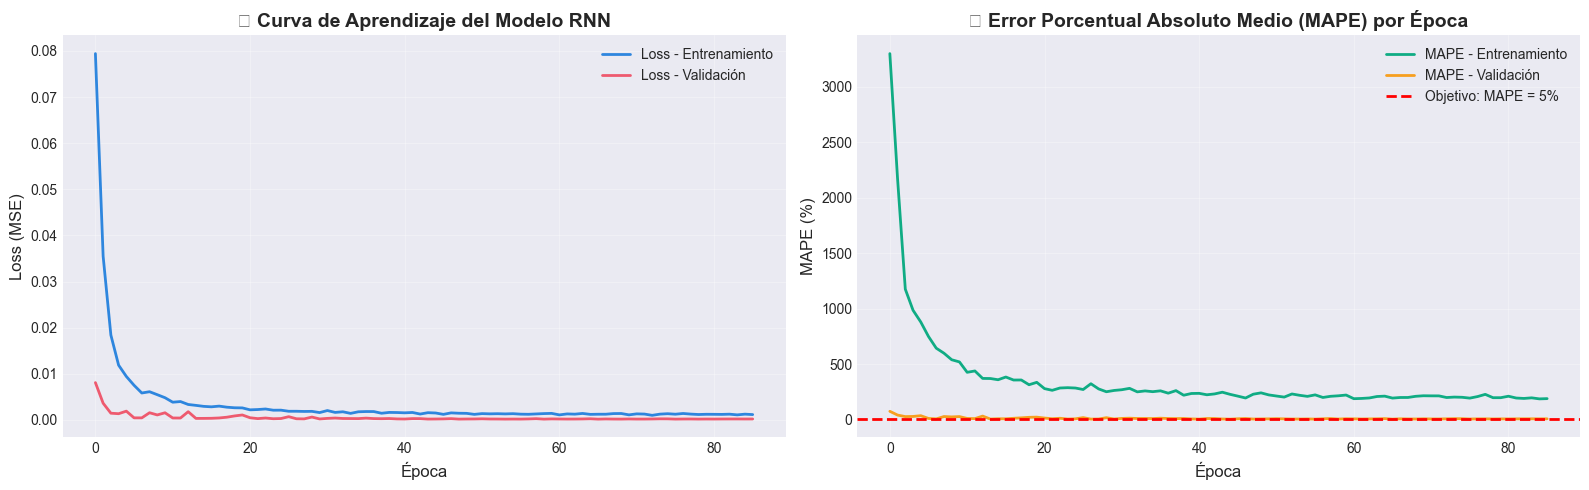

✓ Gráfico guardado: 'rnn_prediccion_completa.png'


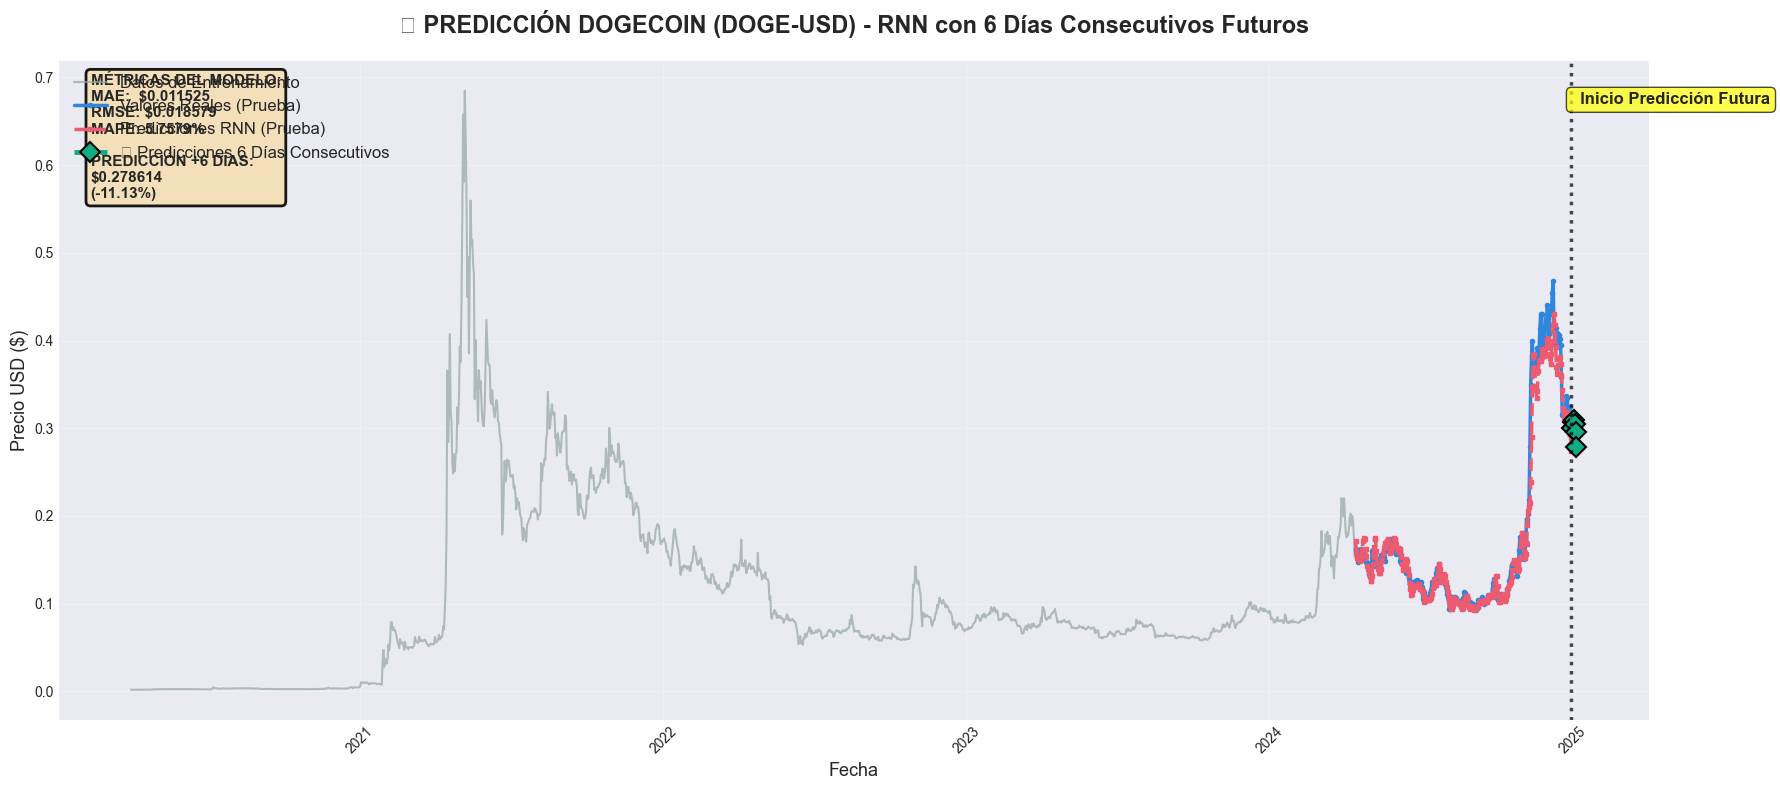

✓ Gráfico guardado: 'rnn_zoom_detallado.png'


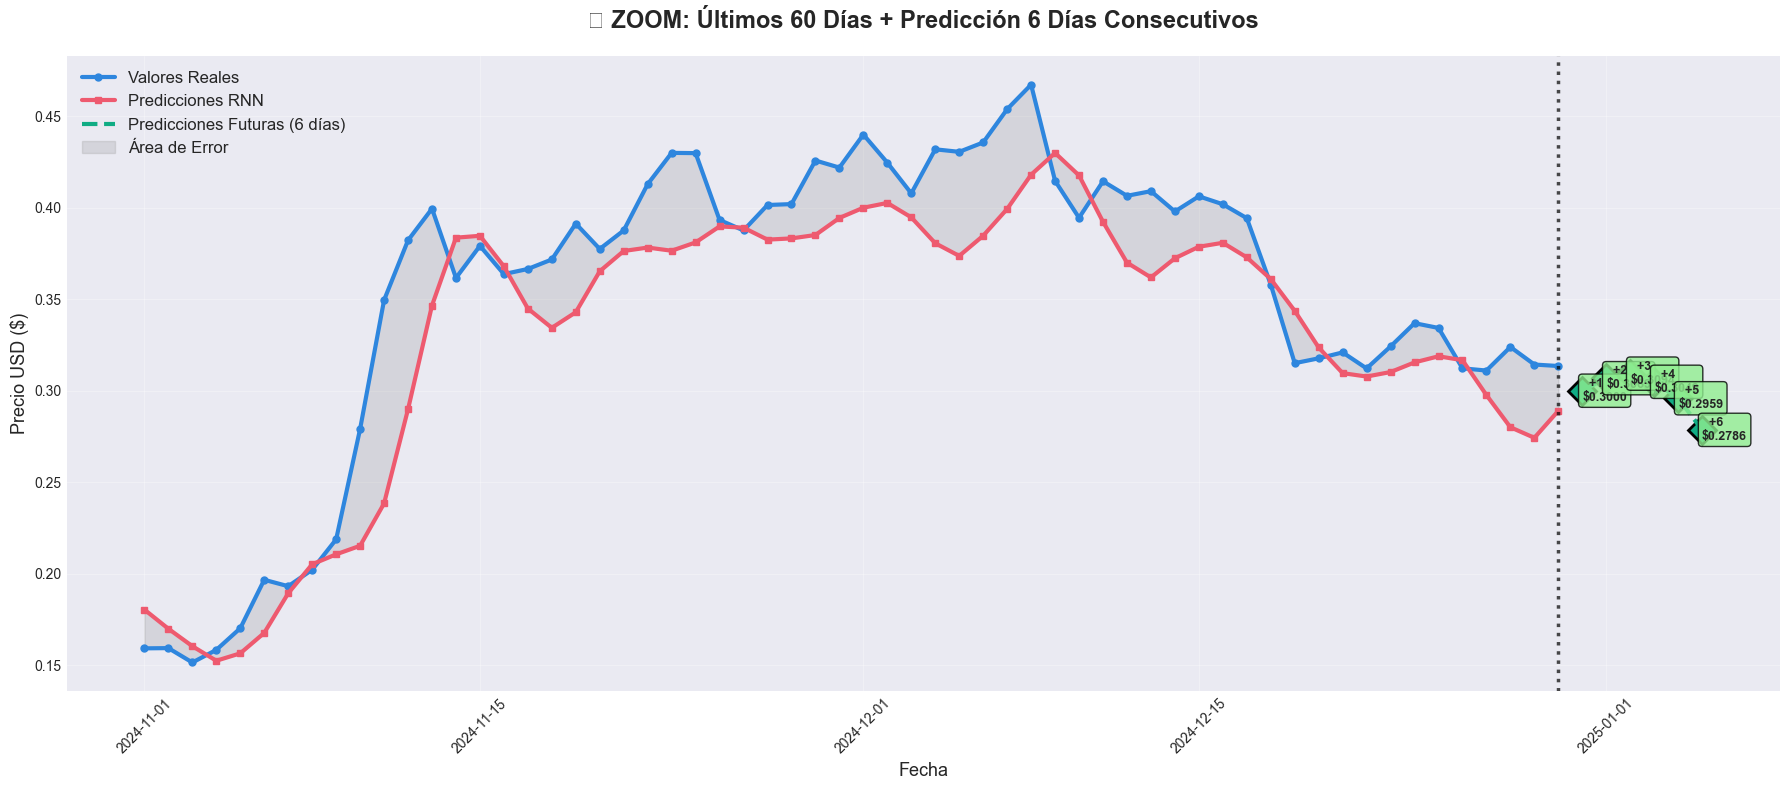

In [34]:
# ============================================================================
# 6️⃣ VISUALIZACIÓN DE RESULTADOS
# ============================================================================
print("\n[6/6] GENERANDO VISUALIZACIONES...")
print("-" * 90)

# Gráfico 1: Curva de aprendizaje
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(history.history['loss'], label='Loss - Entrenamiento', color='#2E86DE', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Loss - Validación', color='#EE5A6F', linewidth=2)
axes[0].set_title('📉 Curva de Aprendizaje del Modelo RNN', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Época', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].legend(loc='upper right', fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['mape'], label='MAPE - Entrenamiento', color='#10AC84', linewidth=2)
axes[1].plot(history.history['val_mape'], label='MAPE - Validación', color='#F79F1F', linewidth=2)
axes[1].axhline(y=5, color='red', linestyle='--', linewidth=2, label='Objetivo: MAPE = 5%')
axes[1].set_title('🎯 Error Porcentual Absoluto Medio (MAPE) por Época', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Época', fontsize=12)
axes[1].set_ylabel('MAPE (%)', fontsize=12)
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rnn_curva_aprendizaje.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico guardado: 'rnn_curva_aprendizaje.png'")
plt.show()

# Gráfico 2: Predicción vs Real + Predicciones Futuras
fig, ax = plt.subplots(figsize=(18, 8))

ax.plot(fechas_train, y_train_real, label='Datos de Entrenamiento', 
        color='#95A5A6', linewidth=1.5, alpha=0.7)
ax.plot(fechas_test, y_test_real, label='Valores Reales (Prueba)', 
        color='#2E86DE', linewidth=2.5, marker='o', markersize=3)
ax.plot(fechas_test, y_pred_test_real, label='Predicciones RNN (Prueba)', 
        color='#EE5A6F', linewidth=2.5, marker='s', markersize=3, linestyle='--')

# Predicciones futuras consecutivas
ax.plot(fechas_futuras, predicciones_futuras, label='📅 Predicciones 6 Días Consecutivos', 
        color='#10AC84', linewidth=3.5, marker='D', markersize=10, linestyle='--', 
        markeredgecolor='black', markeredgewidth=1.5)

# Conectar última observación con primera predicción
ax.plot([ultima_fecha, fechas_futuras[0]], 
        [data[-1, 0], predicciones_futuras[0, 0]], 
        color='#10AC84', linewidth=2.5, linestyle=':', alpha=0.7)

# Línea vertical separando histórico de futuro
ax.axvline(x=ultima_fecha, color='black', linestyle=':', linewidth=2.5, alpha=0.7)
ax.text(ultima_fecha, ax.get_ylim()[1]*0.95, '  Inicio Predicción Futura', 
        rotation=0, verticalalignment='top', fontsize=12, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

ax.set_title('🔮 PREDICCIÓN DOGECOIN (DOGE-USD) - RNN con 6 Días Consecutivos Futuros', 
             fontsize=17, fontweight='bold', pad=20)
ax.set_xlabel('Fecha', fontsize=13)
ax.set_ylabel('Precio USD ($)', fontsize=13)
ax.legend(loc='upper left', fontsize=12, framealpha=0.9)
ax.grid(True, alpha=0.3)

# Información de métricas
textstr = f'MÉTRICAS DEL MODELO:\nMAE:  ${mae_test:.6f}\nRMSE: ${rmse_test:.6f}\nMAPE: {mape_test:.4f}%\n\nPREDICCIÓN +6 DÍAS:\n${precio_predicho_dia6:.6f}\n({cambio_total:+.2f}%)'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.9, edgecolor='black', linewidth=2)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props, fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('rnn_prediccion_completa.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico guardado: 'rnn_prediccion_completa.png'")
plt.show()

# Gráfico 3: Zoom detallado
fig, ax = plt.subplots(figsize=(18, 8))

zoom_dias = 60
fechas_zoom_historico = fechas_test[-zoom_dias:]
valores_zoom_real = y_test_real[-zoom_dias:]
valores_zoom_pred = y_pred_test_real[-zoom_dias:]

# Datos históricos
ax.plot(fechas_zoom_historico, valores_zoom_real, 
        label='Valores Reales', color='#2E86DE', linewidth=3, marker='o', markersize=5)
ax.plot(fechas_zoom_historico, valores_zoom_pred, 
        label='Predicciones RNN', color='#EE5A6F', linewidth=3, marker='s', markersize=5)

# Predicciones futuras
for i, (fecha, precio) in enumerate(zip(fechas_futuras, predicciones_futuras)):
    ax.plot(fecha, precio, marker='D', markersize=14, color='#10AC84', 
            markeredgecolor='black', markeredgewidth=2)
    ax.text(fecha, precio, f'  +{i+1}\n${precio[0]:.4f}', 
            fontsize=9, fontweight='bold', ha='left', va='center',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

ax.plot(fechas_futuras, predicciones_futuras, 
        label='Predicciones Futuras (6 días)', color='#10AC84', linewidth=3, linestyle='--')

# Área de error
ax.fill_between(fechas_zoom_historico, 
                valores_zoom_real.flatten(), 
                valores_zoom_pred.flatten(), 
                alpha=0.2, color='gray', label='Área de Error')

# Línea divisoria
ax.axvline(x=ultima_fecha, color='black', linestyle=':', linewidth=2.5, alpha=0.7)

ax.set_title(f'🔍 ZOOM: Últimos {zoom_dias} Días + Predicción 6 Días Consecutivos', 
             fontsize=17, fontweight='bold', pad=20)
ax.set_xlabel('Fecha', fontsize=13)
ax.set_ylabel('Precio USD ($)', fontsize=13)
ax.legend(loc='upper left', fontsize=12, framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('rnn_zoom_detallado.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico guardado: 'rnn_zoom_detallado.png'")
plt.show()

In [36]:
# ============================================================================
# RESUMEN FINAL
# ============================================================================
print("\n" + "=" * 90)
print("✅ PROCESO COMPLETADO EXITOSAMENTE")
print("=" * 90)

print(f"\n{'='*60}")
print(f"📈 RESUMEN FINAL DE RESULTADOS")
print(f"{'='*60}")

print(f"\n🎯 RENDIMIENTO DEL MODELO:")
print(f"   Conjunto de Entrenamiento:")
print(f"   • MAE:  ${mae_train:.6f}")
print(f"   • RMSE: ${rmse_train:.6f}")
print(f"   • MAPE: {mape_train:.4f}%")

print(f"\n   Conjunto de Prueba:")
print(f"   • MAE:  ${mae_test:.6f}")
print(f"   • RMSE: ${rmse_test:.6f}")
print(f"   • MAPE: {mape_test:.4f}% {'✅ OBJETIVO ALCANZADO!' if mape_test < 5 else '⚠️  Por encima del 5%'}")

print(f"\n🔮 PREDICCIONES FUTURAS (6 DÍAS CONSECUTIVOS):")
for i in range(8):
    cambio_dia = ((predicciones_futuras[i, 0] - (data[-1, 0] if i == 0 else predicciones_futuras[i-1, 0])) / 
                   (data[-1, 0] if i == 0 else predicciones_futuras[i-1, 0]) * 100)
    print(f"   Día +{i+1} ({fechas_futuras[i].strftime('%Y-%m-%d')}): ${predicciones_futuras[i, 0]:.6f} ({cambio_dia:+.2f}%)")

print(f"\n   📊 Cambio Total (6 días): {cambio_total:+.2f}%")
print(f"   📊 Tendencia: {'📈 ALCISTA' if cambio_total > 0 else '📉 BAJISTA'}")

print(f"\n📁 GRÁFICOS GENERADOS:")
print(f"   • rnn_curva_aprendizaje.png")
print(f"   • rnn_prediccion_completa.png")
print(f"   • rnn_zoom_detallado.png")

print("\n" + "=" * 90)
print("🎓 Modelo optimizado listo para documentación en tesis")
print("=" * 90)


✅ PROCESO COMPLETADO EXITOSAMENTE

📈 RESUMEN FINAL DE RESULTADOS

🎯 RENDIMIENTO DEL MODELO:
   Conjunto de Entrenamiento:
   • MAE:  $0.009056
   • RMSE: $0.016998
   • MAPE: 80.7277%

   Conjunto de Prueba:
   • MAE:  $0.011525
   • RMSE: $0.018579
   • MAPE: 5.7579% ⚠️  Por encima del 5%

🔮 PREDICCIONES FUTURAS (6 DÍAS CONSECUTIVOS):
   Día +1 (2024-12-31): $0.300017 (-4.30%)
   Día +2 (2025-01-01): $0.306858 (+2.28%)
   Día +3 (2025-01-02): $0.309352 (+0.81%)
   Día +4 (2025-01-03): $0.304882 (-1.44%)
   Día +5 (2025-01-04): $0.295878 (-2.95%)
   Día +6 (2025-01-05): $0.278614 (-5.83%)


IndexError: index 6 is out of bounds for axis 0 with size 6